# This notebook provides a guideline how to create your own bidder class and to check it on our datasets.

In [1]:
import sys
sys.path.append("../")

In [2]:
import optuna
import pandas as pd
import numpy as np
from typing import Dict

import matplotlib.pyplot as plt

from simulator.simulation.modules import Campaign, History
from simulator.simulation.simulate import simulate_campaign
from simulator.simulation.utils_visualization import data_prep_vis, plot_history_article
from simulator.model.bidder import _Bidder
from simulator.validation.check_results import autobidder_check

### Create bidder with a simple bidding strategy

In [3]:
class AllInBidder(_Bidder):
    """
    A baseline bidder with a simple bidding strategy.

    This class serves as an example of a working bidder and can be used
    as a template for more sophisticated bidding strategies.

    Attributes:
        Any custom attributes can be added here.
    """

    def __init__(self, params: dict = None):
        super().__init__()
        self.day_initial_balance=0

    def place_bid(self, bidding_input_params: Dict[str, any], history: History) -> float:

        start = bidding_input_params['campaign_start_time']
        end = bidding_input_params['campaign_end_time']
        
        desired_hours=72
        
        initial_balance = bidding_input_params['initial_balance']
        
        region_id = bidding_input_params['region_id']
        logical_category = bidding_input_params['logical_category']
        curr_time = bidding_input_params['curr_time']
        prev_time = bidding_input_params['prev_time']
        balance = bidding_input_params['balance']
        prev_balance = bidding_input_params['prev_balance']
        prev_bid = bidding_input_params['prev_bid']
        hour=(bidding_input_params['curr_time'] - start) // 3600+1
        hour_from_cycle_start=hour%24
        initial_cycle_balance = bidding_input_params['initial_balance']
        
        if hour==0:
            pf=200 #hyperparameter!
        else:
            pf = bidding_input_params['prev_bid']
            
        if hour_from_cycle_start==0:    
            self.day_initial_balance=balance
             
        dt=curr_time-prev_time
            
        linear_target_spend=np.arange(0,24)
        
        desired_cycle_balance=initial_balance/desired_hours
        
        spend_error=(self.day_initial_balance-bidding_input_params['balance']-desired_cycle_balance*linear_target_spend[hour_from_cycle_start])
        
        if hour>0:
            gradient_spend_error=(prev_balance-balance-desired_cycle_balance)/dt
        else:
            gradient_spend_error=0

        if gradient_spend_error==0:
            tau=1000000
        else: 
            tau=-spend_error/gradient_spend_error

        if tau<0:
            ws=0.5
            wg=0.5
        else:
            ws=min(0.9,0.2*tau)
            wg=1-ws

        #hyperparameters!
        C_max=50
        C_min=5
        E_max=initial_balance/desired_hours
        E_gmc=initial_balance/desired_hours/2

        spend_error_c=min(C_max, C_max*abs(spend_error)/E_max)

        gradient_spend_error_i=min(1,abs(gradient_spend_error))
        gradient_spend_error_c=max(C_min, C_max*gradient_spend_error_i/E_gmc)
        
        pf = pf-ws*spend_error_c*np.sign(spend_error)-wg*gradient_spend_error_c*np.sign(gradient_spend_error)
        
        bid=pf
        
        #print('hour ',hour_from_cycle_start, 'bid ',bid, 'balance desired ', desired_cycle_balance*linear_target_spend[hour_from_cycle_start], 'spend ', self.day_initial_balance-bidding_input_params['balance'], 'spend_error ', spend_error)
        
        return bid

### Let's check our risky bidder on one campaign's data

In [7]:
auction_mode = 'FPA' # you may also choose the 'VCG' mode
bidder_class = AllInBidder

if auction_mode == 'FPA':
    campaigns_path = '../data/small_example/fpa/subsample_campaigns.csv'
    stats_path = '../data/small_example/fpa/subsample_stats.csv'
elif auction_mode == 'VCG':
    campaigns_path = ''
    stats_path = ''

In [8]:
campaign_df = pd.read_csv(campaigns_path)
stats_df = pd.read_csv(stats_path)

In [9]:
CAMPAIGN_IDX = 5

In [10]:
campaign_data = campaign_df.iloc[CAMPAIGN_IDX]
campaign_example = Campaign(
    item_id=campaign_data['item_id'],
    campaign_id=int(campaign_data['campaign_id']),
    loc_id=int(campaign_data["loc_id"]),
    region_id=int(campaign_data["region_id"]),
    logical_category=campaign_data["logical_category"],
    microcat_ext=int(campaign_data["microcat_ext"]),
    campaign_start=int(campaign_data["campaign_start"]),
    campaign_end=int(campaign_data["campaign_end"]),
    initial_balance=campaign_data['auction_budget'],
    balance=campaign_data['auction_budget'],
    curr_time=int(campaign_data["campaign_start"]),
    prev_time=int(campaign_data["campaign_start"]),
    prev_balance=campaign_data['auction_budget'],
)
campaign_data['auction_budget'], (campaign_data['campaign_end'] - campaign_data['campaign_start']) // 3600

(184.32, 72)

In [11]:
simulation_history = simulate_campaign(
    campaign=campaign_example,
    bidder=bidder_class(),
    stats_file=stats_df,
    auction_mode=auction_mode
)

# Visualization of one campaign's simulation history

In [12]:
df = simulation_history.to_data_frame()
vis_data = data_prep_vis(df)
df.head(2)

/Users/aikhiryanova/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,curr_time,curr_timestamp,campaign_start_time,campaign_end_time,campaign_id,balance,initial_balance,clicks,contacts,bid,...,logical_category,microcat_ext,prev_timestamp,desired_clicks,desired_time,spend,tr_share,tr_share_cs,price_bin,cpc
0,1986-10-23 08:00:00,530427600,530425091,530684291,85376357,183.266994,184.32,0.484773,0.005265,200.000000,...,1.7,2088043,530424000,0,0,1.053006,0.007017,0.007017,29.060290,2.172164
1,1986-10-23 09:00:00,530431200,530425091,530684291,85376357,181.625312,184.32,1.180651,0.012823,217.216742,...,1.7,2088043,530427600,0,0,1.641683,0.008921,0.015938,29.513217,2.359152


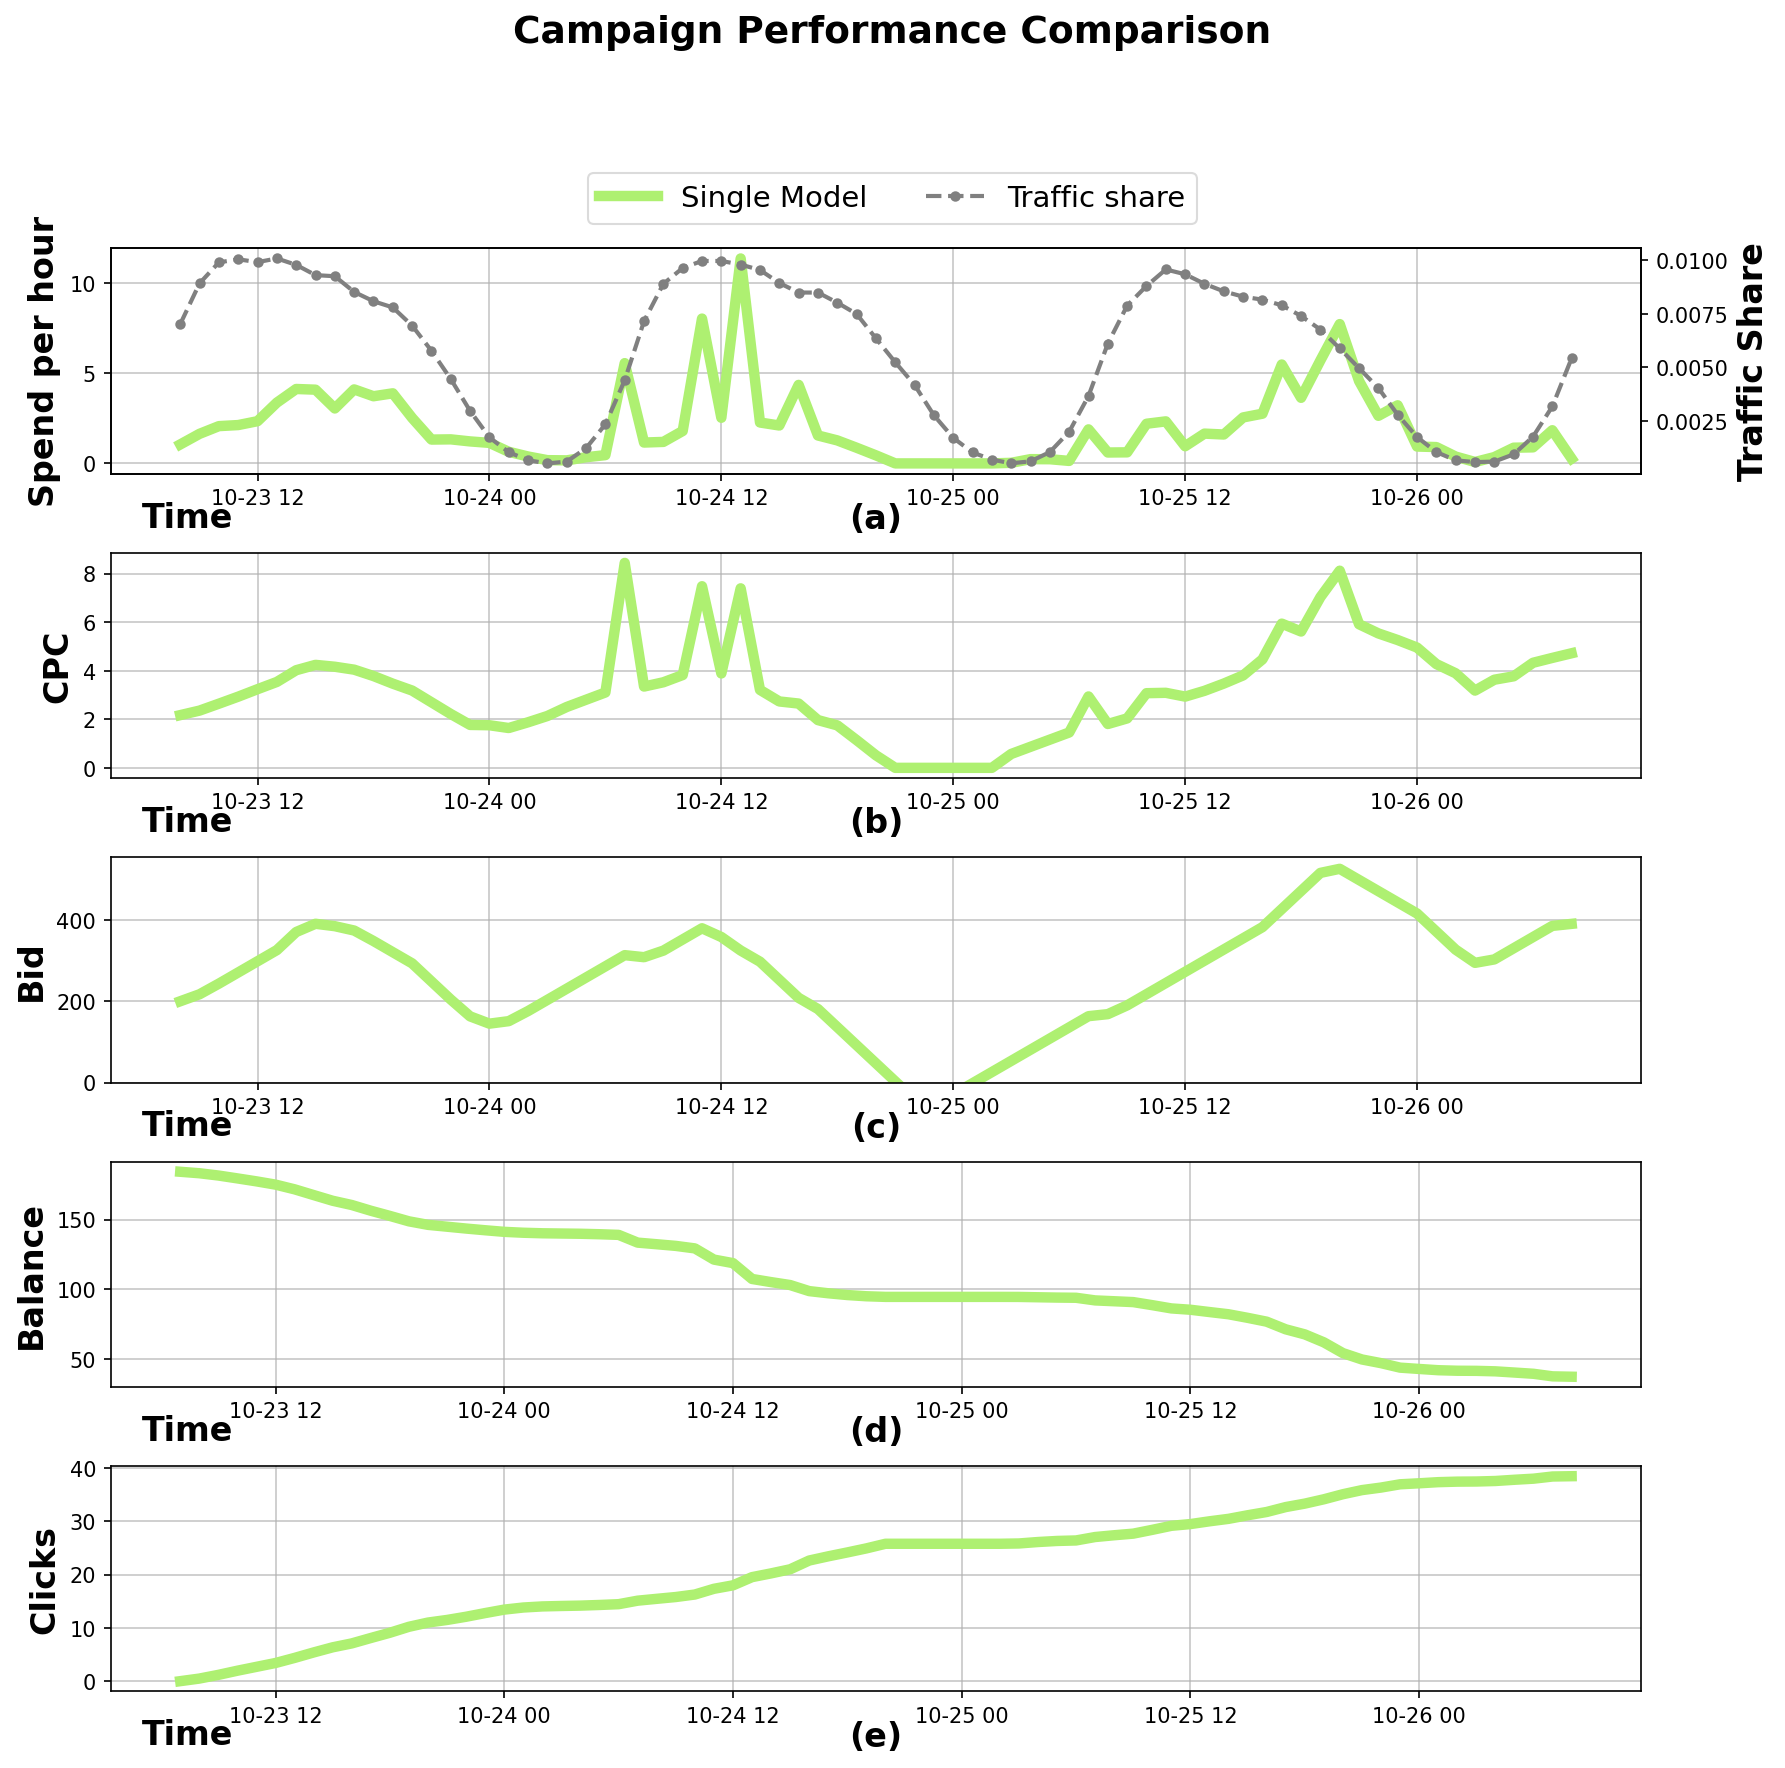

In [13]:
fig = plot_history_article(vis_data)

# Metrics check

In [ ]:
res = autobidder_check(
        bidder=AllInBidder,
        params={
            "input_campaigns": campaigns_path,
            "input_stats": stats_path,
        },
        auction_mode=auction_mode
    )

print(f"MCR: {res['score'][0]}, RMSE_T: {res['score'][1]}")

As you can see, this bidder's performance leaves room for improvement. Good luck with your own bidders, and may your bids be ever in your favor!